In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
#plotting and animation libraries
import matplotlib.pyplot as plt
import seaborn as sns
#clustering libraries
import scipy
import scipy.cluster as cl
import sklearn.cluster as skcl
import sklearn.metrics as skm
#pca library
import sklearn.decomposition as skd
import argparse
import datetime
import sys
sys.path.append('./segmentation_code/')
#My libraries
import SPCR as lvar
import SPCR_calculations as lvarc

In [2]:
f=h5py.File('./sample_data/AllenData_sample.h5','r')
sample_tseries=np.array(f['tseries'],dtype=np.float64)[:5000]
sample_tseries=ma.masked_invalid(sample_tseries)

In [3]:
frameRate=30

## Plot sample time series 

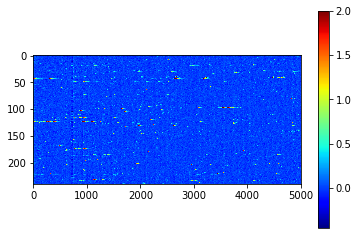

In [4]:
plt.imshow(sample_tseries.T,cmap='jet',vmax=2,aspect=10)
plt.colorbar()
plt.show()

## Define candidate windows 

In [5]:
w0=10
#Define candidate windows
wmax=np.inf
step_fraction=.1
i=w0
w=[]
while i<wmax:
    w.append(i)
    step=int(i*step_fraction)
    if int(i*step_fraction)>w0:
        break
    if step<1:
        step=1
    i+=step

# Adaptive segmentation with regularization

In [6]:
N=1000 #number of samples in the null distribution
per=97.5
lag=1

#break finder
min_size=10
# segs=lvar.segment_maskedArray(tseries,min_size)
breaks_segments=lvar.change_point(w,N,per,sample_tseries,min_size,cond_thresh=1e5)

KeyboardInterrupt: 

## Estimate parameters

In [ ]:
windows_segment,segments=breaks_segments
#compute thetas in the obtained windows_segment
thetas_final=[]
for idx,seg in enumerate(segments):
    segment_windows=np.copy(windows_segment[idx])
    segments_windows=list(segment_windows)
    thetas=[]
    for seg_w in segment_windows:
        i_0,i_f=seg_w
        window_bw=sample_tseries[i_0:i_f]
        theta,coef=lvar.pca_theta_coef(window_bw,frameRate)
        thetas.append(np.vstack(theta))
    thetas_final.append(thetas)
thetas_final=np.concatenate(thetas_final)
windows_final=np.concatenate(windows_segment)

## Window size distribution 

In [ ]:
wsizes=np.hstack(np.diff(windows_final,axis=1))/frameRate

In [ ]:
plt.step(np.sort(wsizes), np.arange(wsizes.size)/wsizes.size) 
plt.ylabel('CDF')
plt.xlabel('Window size (s)')
plt.xlim(0.3,1)
plt.show()

# Eigenvalue spectrum

In [ ]:
all_eigs=[]
for coef in coefs_final:
    all_eigs.append(np.linalg.eigvals(coef))

In [ ]:
eigs_real=np.hstack(all_eigs).real
sel=~(np.abs(eigs_real+frameRate)<1e-10)
eigs_real=eigs_real[sel]
eigs_imag=np.hstack(all_eigs).imag/(2*np.pi)
eigs_imag=eigs_imag[sel]

In [ ]:
from scipy import ndimage as ndi

def density_plot(X,Y,xrange,yrange,n_grid_x,n_grid_y,border=5,smooth=False,log=False):
    # view area range
    view_xmin,view_xmax=xrange
    view_ymin,view_ymax=yrange

    # get data
    xl = X
    yl = Y

    # get visible data points
    xlvis = []
    ylvis = []
    for i in range(0,len(xl)):
        if view_xmin < xl[i] < view_xmax and view_ymin < yl[i] < view_ymax:
            xlvis.append(xl[i])
            ylvis.append(yl[i])

    kx = (n_grid_x - 1) / (view_xmax - view_xmin)
    ky = (n_grid_y - 1) / (view_ymax - view_ymin)
    imgw = (n_grid_x + 2 * border)
    imgh = (n_grid_y + 2 * border)
    img = np.zeros((imgh,imgw))
    for x, y in zip(xl,yl):
        ix = int((x - view_xmin) * kx) + border
        iy = int((y - view_ymin) * ky) + border
        if 0 <= ix < imgw and 0 <= iy < imgh:
            img[iy][ix] += 1
    if smooth:
        if log:
            log_img=np.log10(img)
            sel=~np.isfinite(log_img)
            log_img[sel]=0.
            filtered_img=ndi.gaussian_filter(log_img, (border,border))
            return filtered_img
        else:
            return ndi.gaussian_filter(img, (border,border))  ## gaussian convolution
    else:
        if log:
            return np.log10(img)
        else:
            return img

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors

xrange=[-30,30]
yrange=[0,6]
r=10
n_grid=256

density=density_plot(eigs_real,np.abs(eigs_imag),xrange,yrange,n_grid,n_grid,border=r,smooth=True)
data=density/density.max()
plt.imshow(data , origin='lower', extent=[xrange[0], xrange[1], yrange[0], yrange[1]],cmap=cm.jet,
           aspect=10,norm=colors.SymLogNorm(linthresh=1e-2, linscale=1,vmin=1e-2, vmax=data.max()))
plt.colorbar()
# plt.scatter(analytical_eigvals.real,analytical_eigvals.imag/(2*np.pi),s=50)
# plt.xlim(-2,2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(' $\lambda_r$',fontsize=20)
plt.ylabel('$\lambda_i$',fontsize=20)
plt.axvline(0,ls='--')
plt.grid(False)
# plt.scatter(analytical_eigvals.real,analytical_eigvals.imag/(2*np.pi),s=50,color='white')
# plt.savefig('EigSpectrum_Allen.eps')
plt.show()